In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
# Đọc dữ liệu
serial = pd.read_csv("./openmp/gwo_serial_rastrigin.csv")
parallel = pd.read_csv("./openmp/gwo_parallel_rastrigin.csv")
# print(serial.head())
# print(parallel.head())

# Vẽ biểu đồ phân tích

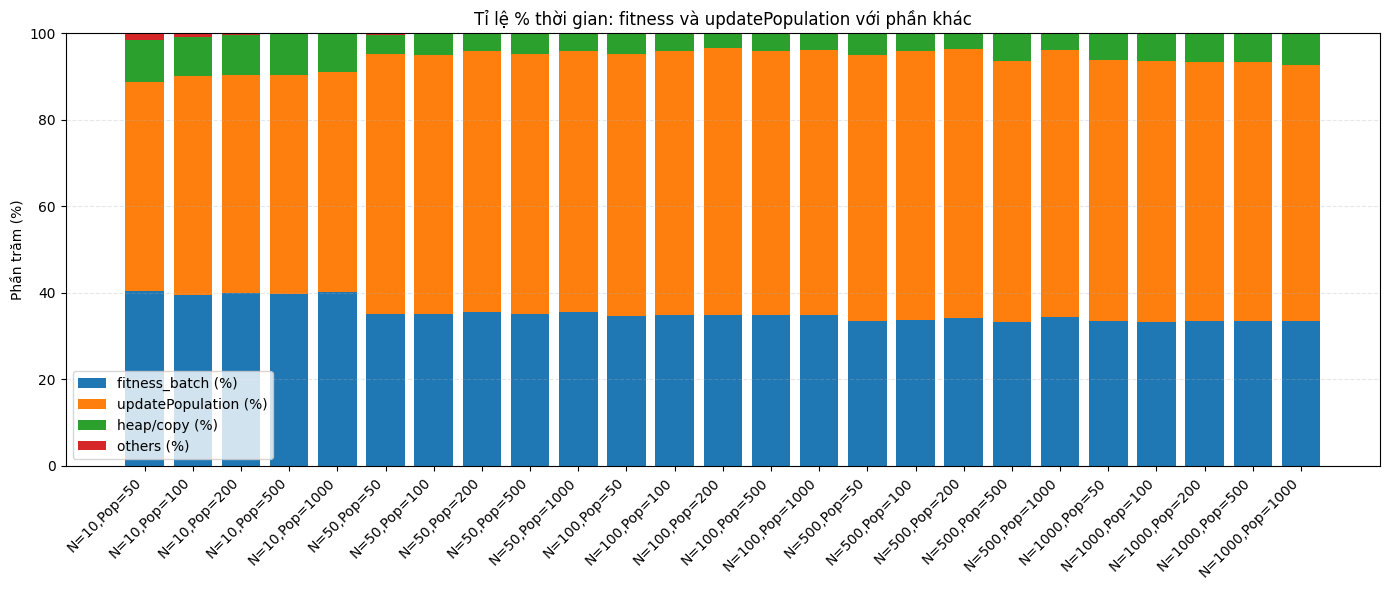

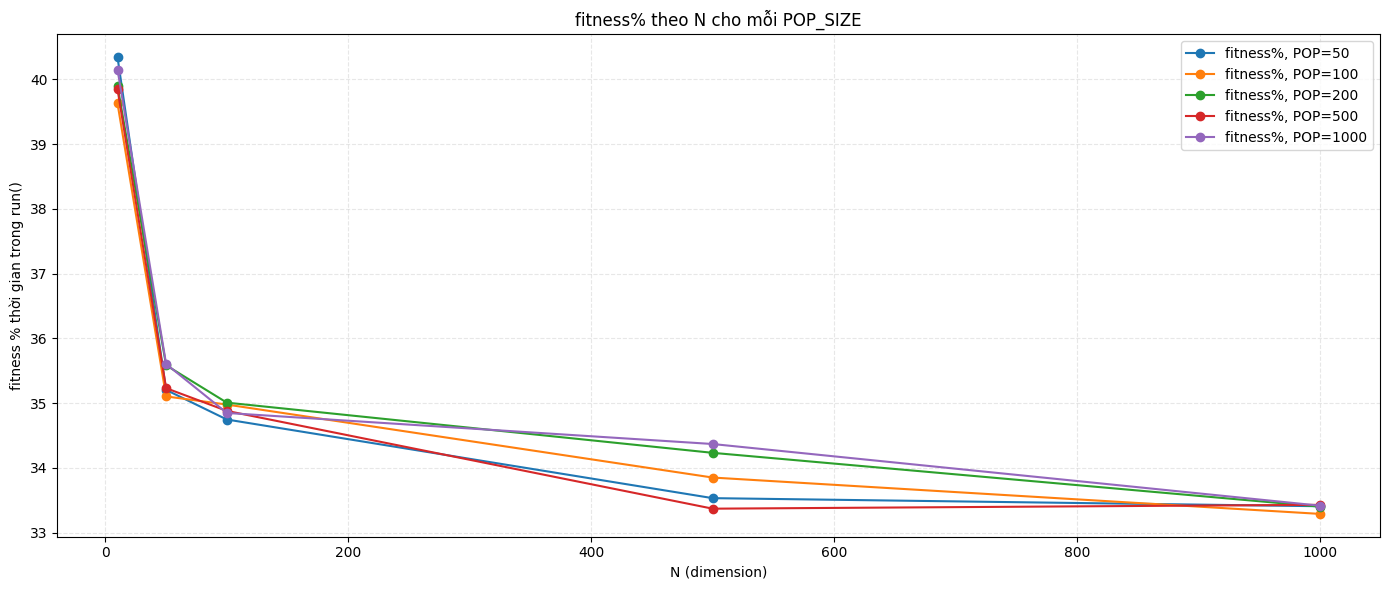

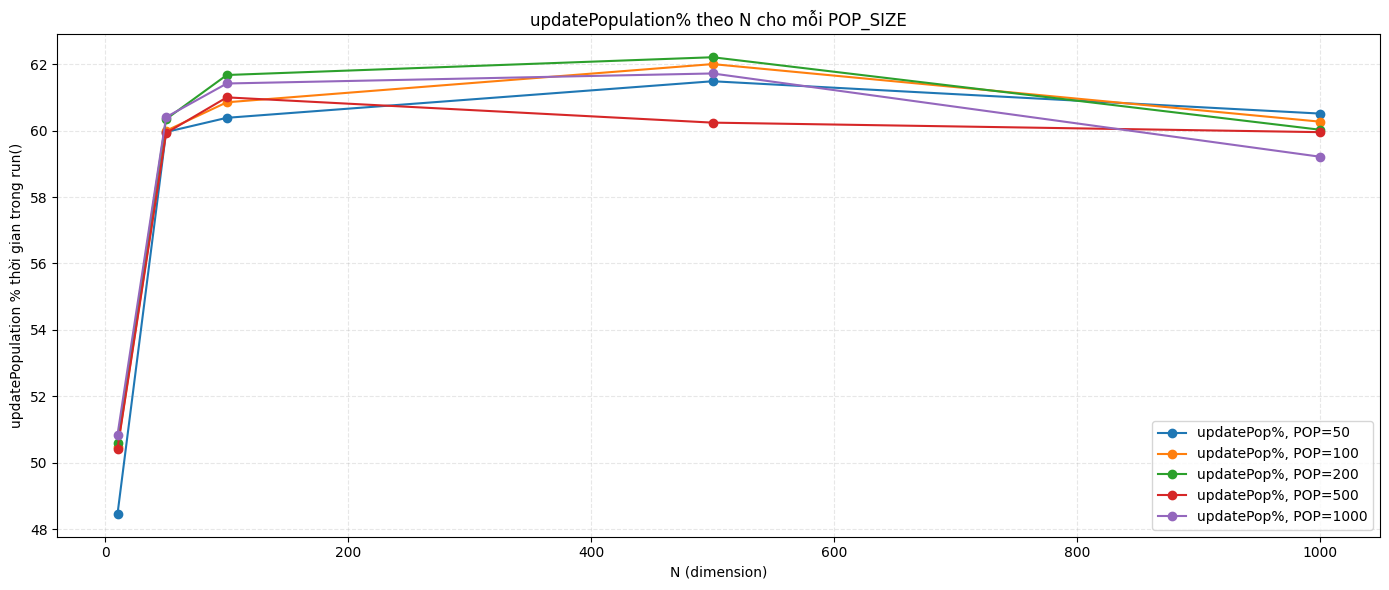

In [13]:
out_dir = Path("plots_analyze")
out_dir.mkdir(exist_ok=True)

# Tạo một cột label cho từng cấu hình
serial_analyze["config"] = serial_analyze.apply(lambda row: f"N={row['N']},Pop={row['POP_SIZE']}", axis=1)

# Sắp xếp
serial_analyze = serial_analyze.sort_values(by=["N", "POP_SIZE"])

# Vẽ stacked bar: % fitness + % updatePopulation ---

x = range(len(serial_analyze))
fit_pct  = serial_analyze["fit_pct"]
upd_pct  = serial_analyze["upd_pct"]
heap_pct = serial_analyze["heap_pct"]
other_pct= serial_analyze["other_pct"]

plt.figure(figsize=(14, 6))
plt.title("Tỉ lệ % thời gian: fitness và updatePopulation với phần khác")
plt.xticks(x, serial_analyze["config"], rotation=45, ha="right")

# Stacked bars
p1 = plt.bar(x, fit_pct, label="fitness_batch (%)")
p2 = plt.bar(x, upd_pct, bottom=fit_pct, label="updatePopulation (%)")
p3 = plt.bar(x, heap_pct, bottom=fit_pct+upd_pct, label="heap/copy (%)")
p4 = plt.bar(x, other_pct, bottom=fit_pct+upd_pct+heap_pct, label="others (%)")

plt.ylabel("Phần trăm (%)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.savefig(out_dir /"gwo_stacked_percent.png", dpi=200)

# Vẽ line chart theo N cho một vài POP_SIZE  ---

pop_values = sorted(serial_analyze["POP_SIZE"].unique())

plt.figure(figsize=(14, 6))
for pop in pop_values:
    sub = serial_analyze[serial_analyze["POP_SIZE"] == pop]
    plt.plot(sub["N"], sub["fit_pct"],
                marker="o", linestyle="-",
                label=f"fitness%, POP={pop}")

plt.title("fitness% theo N cho mỗi POP_SIZE")
plt.xlabel("N (dimension)")
plt.ylabel("fitness % thời gian trong run()")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(out_dir /"gwo_fit_percent_vs_N.png", dpi=200)

# Tương tự cho updatePopulation
plt.figure(figsize=(14, 6))
for pop in pop_values:
    sub = serial_analyze[serial_analyze["POP_SIZE"] == pop]
    plt.plot(sub["N"], sub["upd_pct"],
                marker="o", linestyle="-",
                label=f"updatePop%, POP={pop}")

plt.title("updatePopulation% theo N cho mỗi POP_SIZE")
plt.xlabel("N (dimension)")
plt.ylabel("updatePopulation % thời gian trong run()")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(out_dir /"gwo_upd_percent_vs_N.png", dpi=200)


# Vẽ biểu đồ theo N và PopSize

In [14]:
# Ghép dữ liệu serial & parallel
merged = parallel.merge(
    serial[["problem", "N", "POP_SIZE", "avg_ms"]],
    on=["problem", "N", "POP_SIZE"],
    suffixes=("_par", "_ser")
)

# Tính speedup & efficiency
merged["speedup"] = merged["avg_ms_ser"] / merged["avg_ms_par"]
merged["efficiency"] = merged["speedup"] / merged["threads"]

merged.to_csv("gwo_summary.csv", index=False)

print("== Một vài dòng kết quả tính speedup/efficiency ==")
print(merged[["problem", "N", "POP_SIZE", "threads",
              "avg_ms_ser", "avg_ms_par",
              "speedup", "efficiency"]].head())


# Vẽ biểu đồ speedup & efficiency cho từng cặp (problem, N, POP_SIZE)
out_dir = Path("plots")
out_dir.mkdir(exist_ok=True)

configs = merged[["problem", "N", "POP_SIZE"]].drop_duplicates()

for _, row in configs.iterrows():
    prob = row["problem"]
    N = row["N"]
    pop = row["POP_SIZE"]

    sub = merged[
        (merged["problem"] == prob) &
        (merged["N"] == N) &
        (merged["POP_SIZE"] == pop)
    ].sort_values("threads")

    if sub.empty:
        continue

    threads = sub["threads"].astype(int).to_list()

    # ----- Speedup -----
    plt.figure()
    plt.plot(threads, sub["speedup"], marker="o")
    plt.xlabel("Threads")
    plt.ylabel("Speedup")
    plt.title(f"{prob} - N={N}, POP={pop} - Speedup")

    plt.xticks(threads)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"speedup_{prob}_N{N}_POP{pop}.png", dpi=150)
    plt.close()

    # ----- Efficiency -----
    plt.figure()
    plt.plot(threads, sub["efficiency"], marker="o")
    plt.xlabel("Threads")
    plt.ylabel("Efficiency")
    plt.title(f"{prob} - N={N}, POP={pop} - Efficiency")

    plt.xticks(threads) 
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"efficiency_{prob}_N{N}_POP{pop}.png", dpi=150)
    plt.close()

print("Đã lưu:")
print("  - gwo_summary.csv")
print("  - các biểu đồ speedup_*.png, efficiency_*.png trong thư mục 'plots'")


== Một vài dòng kết quả tính speedup/efficiency ==
     problem   N  POP_SIZE  threads  avg_ms_ser  avg_ms_par   speedup  \
0  Rastrigin  10        50        2        12.6        17.6  0.715909   
1  Rastrigin  10        50        4        12.6        19.6  0.642857   
2  Rastrigin  10        50        8        12.6        25.4  0.496063   
3  Rastrigin  10        50       16        12.6        38.0  0.331579   
4  Rastrigin  10        50       20        12.6        47.8  0.263598   

   efficiency  
0    0.357955  
1    0.160714  
2    0.062008  
3    0.020724  
4    0.013180  
Đã lưu:
  - gwo_summary.csv
  - các biểu đồ speedup_*.png, efficiency_*.png trong thư mục 'plots'


# Vẽ biểu đồ heatmap

In [15]:
# Gộp dataset
merged = parallel.merge(
    serial,
    on=["problem", "N", "POP_SIZE"],
    suffixes=("_par", "_ser")
)

# Tính speedup & efficiency cho TỪNG cấu hình threads
merged["speedup"] = merged["avg_ms_ser"] / merged["avg_ms_par"]
merged["efficiency"] = merged["speedup"] / merged["threads"]

out = Path("plots_best_thread")
out.mkdir(exist_ok=True)

# Chọn thread có EFFICIENCY lớn nhất cho từng (N, POP)
best_eff = merged.loc[
    merged.groupby(["N", "POP_SIZE"])["efficiency"].idxmax()
].reset_index(drop=True)

# Heatmap: Efficiency (best theo efficiency)
pivot_eff = best_eff.pivot_table(
    index="N",
    columns="POP_SIZE",
    values="efficiency"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_eff, annot=True, fmt=".2f", cmap="viridis", cbar=False)
plt.title("Heatmap efficiency tốt nhất")
plt.ylabel("N")
plt.xlabel("POP_SIZE")
plt.savefig(out / "heatmap_efficiency_bestEff.png", dpi=150)
plt.close()

# Heatmap: Threads tương ứng (best theo efficiency)
pivot_thr_eff = best_eff.pivot_table(
    index="N",
    columns="POP_SIZE",
    values="threads"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_thr_eff, annot=True, fmt=".0f", cmap="coolwarm", cbar=False)
plt.title("Heatmap số luồng tốt nhất theo efficiency")
plt.ylabel("N")
plt.xlabel("POP_SIZE")
plt.savefig(out / "heatmap_bestThreads_byEfficiency.png", dpi=150)
plt.close()

# Chọn thread có SPEEDUP lớn nhất cho từng (N, POP)
best_spd = merged.loc[
    merged.groupby(["N", "POP_SIZE"])["speedup"].idxmax()
].reset_index(drop=True)

# Heatmap: Speedup (best theo speedup)
pivot_spd = best_spd.pivot_table(
    index="N",
    columns="POP_SIZE",
    values="speedup"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_spd, annot=True, fmt=".2f", cmap="magma", cbar=False)
plt.title("Heatmap speedup tốt nhất")
plt.ylabel("N")
plt.xlabel("POP_SIZE")
plt.savefig(out / "heatmap_speedup_bestSpd.png", dpi=150)
plt.close()

# Heatmap: Threads tương ứng (best theo speedup)
pivot_thr_spd = best_spd.pivot_table(
    index="N",
    columns="POP_SIZE",
    values="threads"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_thr_spd, annot=True, fmt=".0f", cmap="coolwarm", cbar=False)
plt.title("Heatmap số luồng tốt nhất theo speedup")
plt.ylabel("N")
plt.xlabel("POP_SIZE")
plt.savefig(out / "heatmap_bestThreads_bySpeedup.png", dpi=150)
plt.close()
